## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import label_binarize

# Ensure stopwords are downloaded for TextBlob processing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load and Explore the Dataset



In [2]:
# Load the dataset 
df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
print(df.head())

# Check the structure of the dataset
print(df.info())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   

## Data Cleaning

In [3]:
# Drop rows with missing values in 'text' or 'selected_text'
df.dropna(subset=['text', 'selected_text'], inplace=True)

# Drop duplicates if any
df.drop_duplicates(subset=['text'], inplace=True)

In [4]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


## Analyze Sentiment with TextBlob


To compare the pre-labeled sentiment with TextBlob’s sentiment analysis, we will calculate TextBlob’s sentiment for each text entry.

In [5]:
def analyze_sentiment(text):
    # Use TextBlob to get the polarity score
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply TextBlob sentiment analysis
df['TextBlob_Sentiment'] = df['text'].apply(analyze_sentiment)

# Display counts for both the original sentiment and TextBlob's sentiment
print("Original Sentiment Counts:\n", df['sentiment'].value_counts())
print("TextBlob Sentiment Counts:\n", df['TextBlob_Sentiment'].value_counts())

Original Sentiment Counts:
 sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64
TextBlob Sentiment Counts:
 TextBlob_Sentiment
positive    12619
neutral      9427
negative     5434
Name: count, dtype: int64


In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Define the mapping order for sentiment categories
sentiment_order = [['negative', 'neutral', 'positive']]

# Initialize the OrdinalEncoder with categories in the desired order
encoder = OrdinalEncoder(categories=sentiment_order)

# Reshape sentiment column to 2D array as required by OrdinalEncoder
df['sentiment_encoded'] = encoder.fit_transform(df[['sentiment']])

# Display the result
print(df[['sentiment', 'sentiment_encoded']].head())

  sentiment  sentiment_encoded
0   neutral                1.0
1  negative                0.0
2  negative                0.0
3  negative                0.0
4  negative                0.0


## Visualization of Sentiment Distribution


### Original Sentiment Distribution

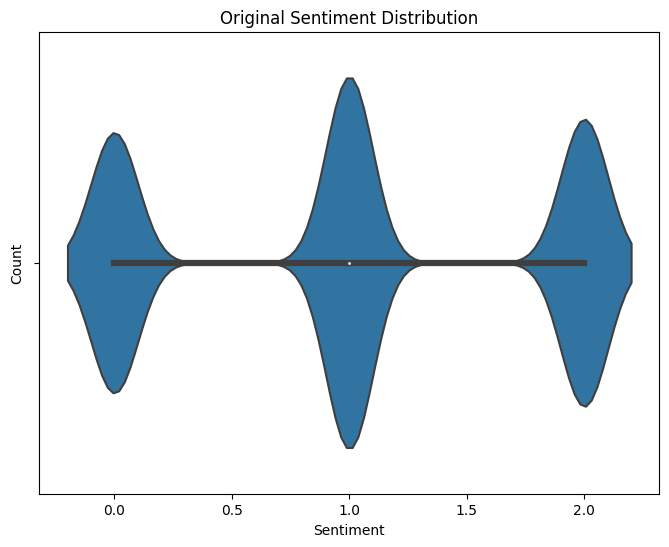

In [7]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x='sentiment_encoded')
plt.title('Original Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### TextBlob Sentiment Distribution

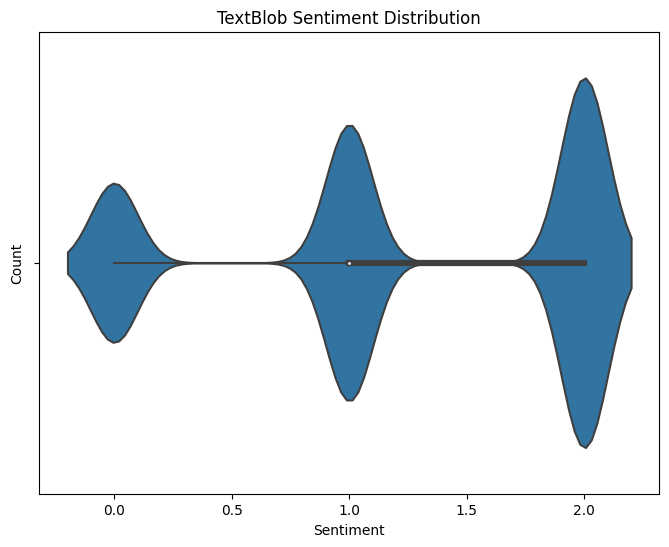

In [8]:
df['TextBlob_Sentiment_encoded'] = encoder.fit_transform(df[['TextBlob_Sentiment']])
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x='TextBlob_Sentiment_encoded')
plt.title('TextBlob Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Word Clouds for Each Sentiment Category

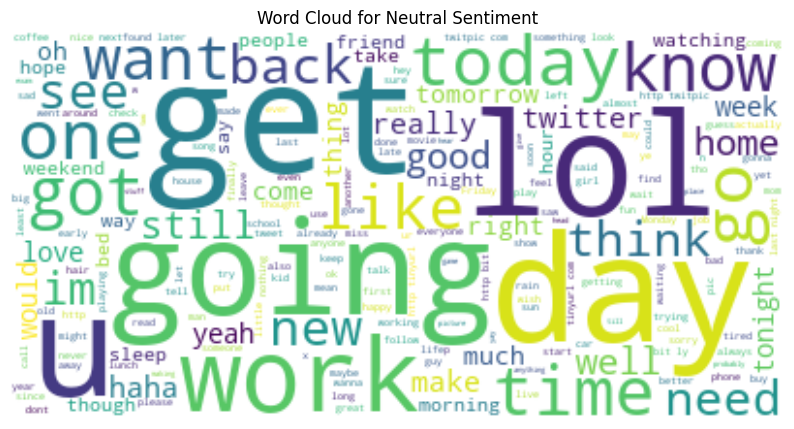

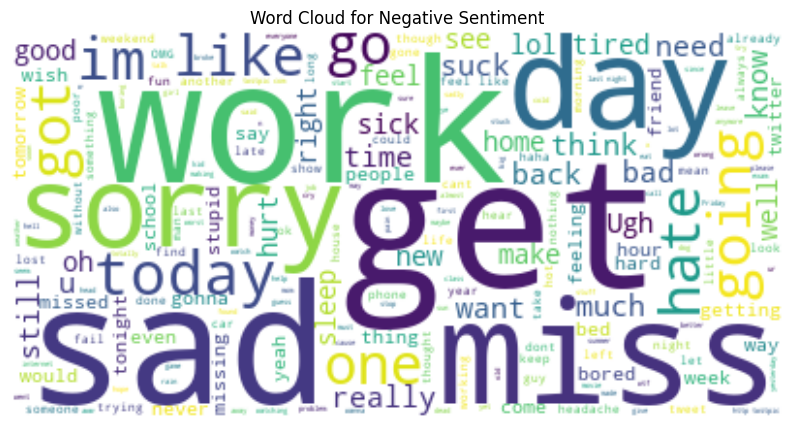

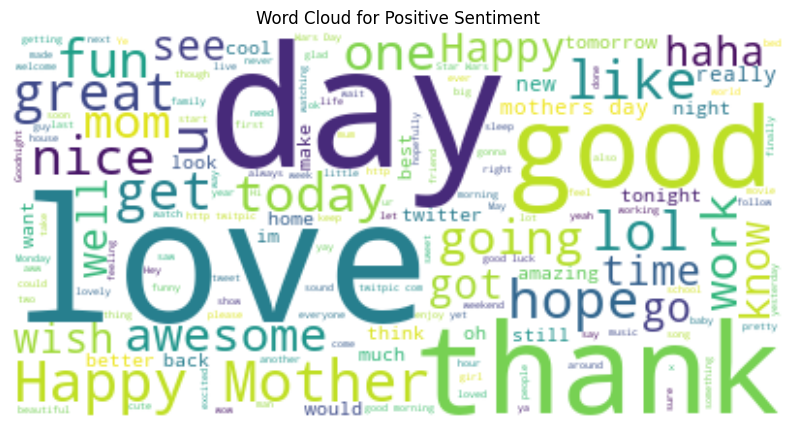

In [9]:
def plot_wordcloud(sentiment_label, sentiment_column):
    # Filter the DataFrame based on the specified sentiment column
    text = " ".join(review for review in df[df[sentiment_column] == sentiment_label].text)
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment_label.capitalize()} Sentiment")
    plt.show()

# Plot word clouds for each sentiment in the original labels
for sentiment in df['sentiment'].unique():
    plot_wordcloud(sentiment, 'sentiment')


## Training Custom Model

### Preprocess the Text

In [10]:
# Clean the text by removing stopwords and punctuation
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and keep alphabetic words only
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

### Split Data and Vectorize

In [11]:
# Split data into features and labels
X = df['cleaned_text']
y = df['sentiment']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
# Dictionary to store models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}


Naive Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.47      0.57      1572
     neutral       0.56      0.77      0.65      2236
    positive       0.72      0.61      0.66      1688

    accuracy                           0.63      5496
   macro avg       0.67      0.61      0.63      5496
weighted avg       0.66      0.63      0.63      5496



<Figure size 1200x800 with 0 Axes>

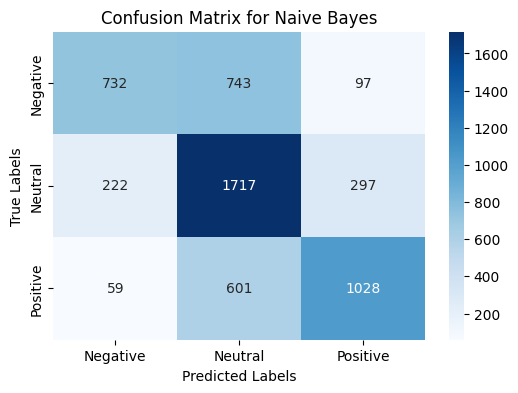


Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.58      0.64      1572
     neutral       0.63      0.75      0.68      2236
    positive       0.77      0.71      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496



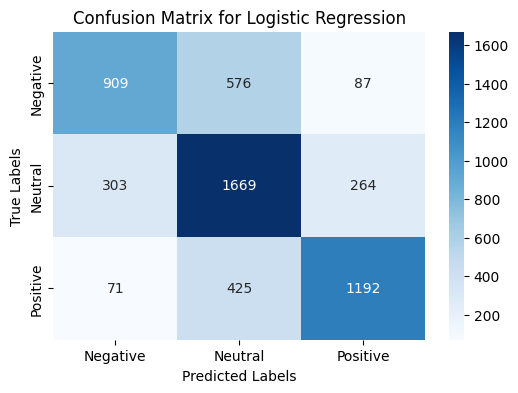


SVM Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.58      0.64      1572
     neutral       0.64      0.77      0.70      2236
    positive       0.79      0.71      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.72      0.69      0.70      5496
weighted avg       0.71      0.70      0.70      5496



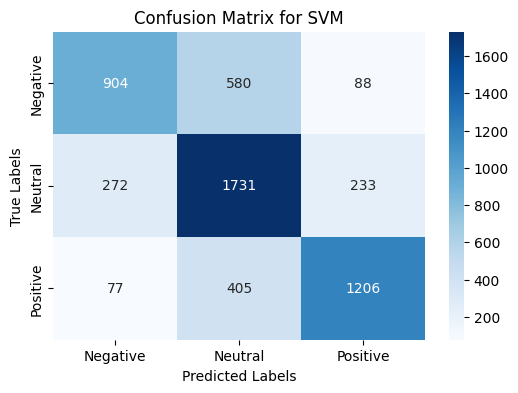


Random Forest Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.60      0.66      1572
     neutral       0.67      0.73      0.70      2236
    positive       0.73      0.77      0.75      1688

    accuracy                           0.71      5496
   macro avg       0.71      0.70      0.70      5496
weighted avg       0.71      0.71      0.70      5496



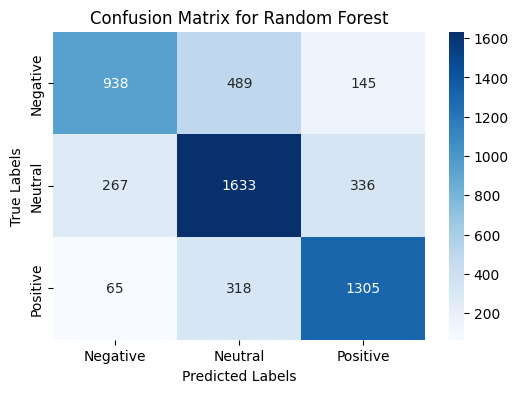

In [13]:
# Initialize lists to store evaluation results
model_names = []
accuracies = []

# Prepare y labels for ROC AUC (one-hot encoded for multi-class ROC AUC)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Set up a figure for plotting ROC curves
plt.figure(figsize=(12, 8))

# Loop through each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Predict the labels and calculate accuracy
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Check if the model has predict_proba or decision_function attribute for ROC AUC calculation
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_tfidf)
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test_tfidf)
    else:
        y_pred_proba = None

    # Append accuracy and model name
    model_names.append(model_name)
    accuracies.append(accuracy)

    # Print classification report
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


### Different Models Comparison

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


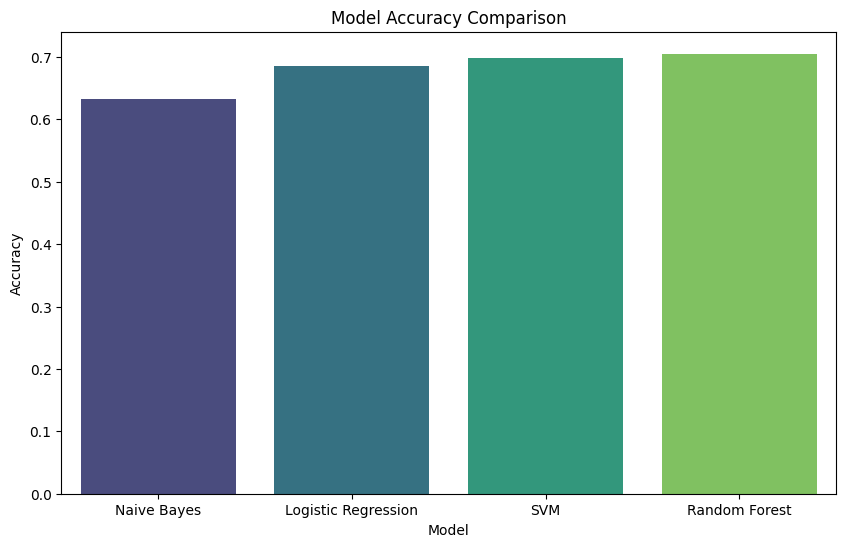

In [14]:
# Plot Model Accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

## Summary Table of Metrics

In [18]:
# Create a DataFrame to summarize metrics
summary_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
})

# Display summary
print(summary_df)

                 Model  Accuracy
0          Naive Bayes  0.632642
1  Logistic Regression  0.685953
2                  SVM  0.698872
3        Random Forest  0.705240
